In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from collections import defaultdict
import numpy as np
from scipy.stats import gaussian_kde
from scipy.stats import mannwhitneyu
from itertools import combinations
from statistics import mean, stdev

In [3]:
# Load unique validated interactions
file_path = "TarBase_miRTarBase_unique_interactions.xlsx"
tarbase = pd.read_excel(file_path, sheet_name=0)
mirtarbase = pd.read_excel(file_path, sheet_name=1)

In [5]:
# miRNAs of interest: Top 5 validated miRNAs (see DIANA TarBase vs miRTarBase notebook)
mirnas = [
    "hsa-miR-155-5p",
    "hsa-miR-145-5p",
    "hsa-miR-21-5p",
    "hsa-miR-34a-5p",
    "hsa-miR-124-3p"
]

In [7]:
# Get intersection of validated interactions
def get_intersections(df1, df2, mirna):
    df1 = df1.rename(columns={"mirna_name": "miRNA", "gene_name": "gene"})
    df2 = df2.rename(columns={"miRNA": "miRNA", "Target Gene": "gene"})

    df1_miRNA = df1[df1["miRNA"] == mirna]
    df2_miRNA = df2[df2["miRNA"] == mirna]

    intersect = pd.merge(df1_miRNA, df2_miRNA, on=["miRNA", "gene"], how="inner")
    return intersect

In [9]:
# Function to load predicted genes for a miRNA - from individual miRNA prediction files
def load_predicted_genes(mirna):
    base = f"{mirna} -"
    files = [
        f"{mirna} - Diana microT CDS.xlsx",
        f"{mirna} - miRDB.xlsx",
        f"{mirna} - mirmap.xlsx"
    ]
    columns = ["gene_symbol", "Gene Symbol", "Gene"]
    
    predicted_genes = set()
    
    for file, col in zip(files, columns):
        if os.path.exists(file):
            df = pd.read_excel(file)
            if col in df.columns:
                genes = df[col].dropna().astype(str).str.upper()
                predicted_genes.update(genes)
            else:
                print(f"⚠️ Column '{col}' not found in {file}")
        else:
            print(f"❌ File not found: {file}")
    
    return predicted_genes

In [13]:
# Count predicted and not predicted validated interactions (from either prediction tool)
results = []

for mirna in mirnas:
    validated = get_intersections(tarbase, mirtarbase, mirna)
    validated['gene_upper'] = validated['gene'].str.upper()
    
    predicted_genes = load_predicted_genes(mirna)
    
    predicted_count = validated['gene_upper'].isin(predicted_genes).sum()
    not_predicted_count = len(validated) - predicted_count
    
    results.append({
        "miRNA": mirna,
        "Predicted": predicted_count,
        "Not Predicted": not_predicted_count,
        "Total": len(validated)
    })

In [17]:
df_plot = pd.DataFrame(results)
df_plot = df_plot.set_index("miRNA")

In [19]:
df_plot.head()

,Predicted,Not Predicted,Total
miRNA,,,
hsa-miR-155-5p,108,4,112
hsa-miR-145-5p,30,5,35
hsa-miR-21-5p,34,7,41
hsa-miR-34a-5p,38,2,40
hsa-miR-124-3p,29,0,29


Do you want to save the chart as a PNG file? (yes/no):  no


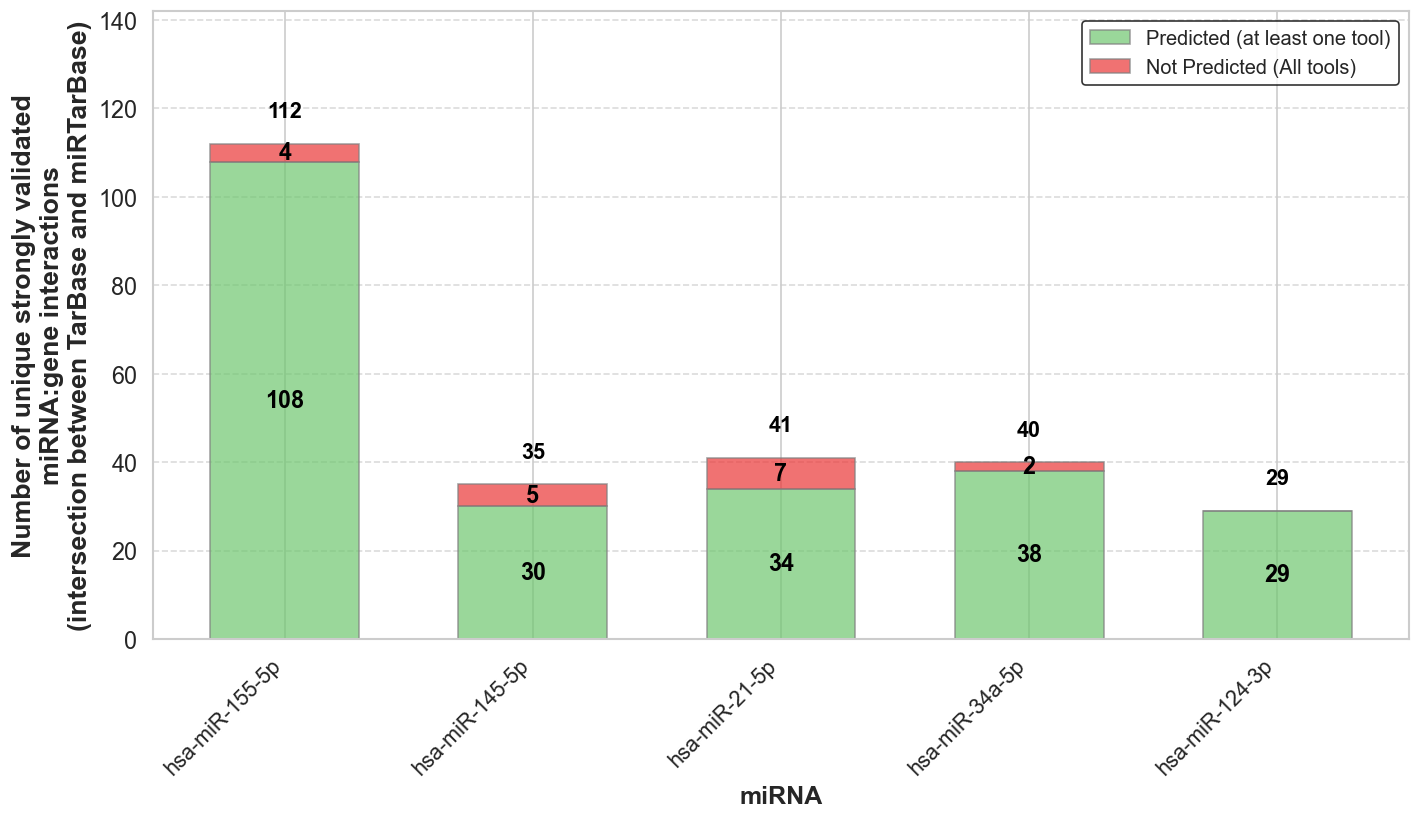

In [57]:
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 7), dpi=120)
bar_width = 0.6

# Prepare data
miRNAs = df_plot.index.tolist()
true_positives_predicted = df_plot["Predicted"].tolist()
not_predicted_all_tools = df_plot["Not Predicted"].tolist()
true_positives_total = df_plot["Total"].tolist()

colors = {
    "Predicted (at least one tool)": "#6fc76f",
    "Not Predicted (All tools)": "#eb3636"
}

p1 = ax.bar(miRNAs, true_positives_predicted, bar_width,
            label="Predicted (at least one tool)",
            color=colors["Predicted (at least one tool)"],
            edgecolor='grey', linewidth=1, alpha=0.7)

p2 = ax.bar(miRNAs, not_predicted_all_tools, bar_width,
            bottom=true_positives_predicted,
            label="Not Predicted (All tools)",
            color=colors["Not Predicted (All tools)"],
            edgecolor='grey', linewidth=1, alpha=0.7)


ax.set_ylim(0, max(true_positives_total) + 30)
ax.set_xlabel("miRNA", fontsize=15, fontweight="bold")
ax.set_ylabel("Number of unique strongly validated\nmiRNA:gene interactions\n(intersection between TarBase and miRTarBase)", fontsize=16, fontweight="bold")
plt.xticks(rotation=45, ha="right", fontsize=13)
ax.tick_params(axis='y', labelsize=14)
ax.grid(axis="y", linestyle="--", alpha=0.7)


for bars in [p1, p2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + height / 2,
                str(int(height)),
                ha="center", va="center",
                fontsize=14, color="black", fontweight="bold"
            )

for i, total in enumerate(true_positives_total):
    ax.text(i, total + 6, str(total), ha="center", fontsize=13, fontweight="bold", color="black")

ax.legend(loc="upper right", fontsize=12, frameon=True, facecolor='white', edgecolor='black')

plt.tight_layout()

save_chart = input("Do you want to save the chart as a PNG file? (yes/no): ").strip().lower()
if save_chart == "yes":
    filename = "miRNA_TruePositives_StackedBar_intersection_noTargetScan.png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    print(f"✅ Chart saved as '{filename}'")

plt.show()

In [ ]:
#UNION

In [21]:
def get_union_validated(df1, df2, mirna):
    df1 = df1.rename(columns={"mirna_name": "miRNA", "gene_name": "gene"})
    df2 = df2.rename(columns={"miRNA": "miRNA", "Target Gene": "gene"})

    df1_miRNA = df1[df1["miRNA"] == mirna][["miRNA", "gene"]]
    df2_miRNA = df2[df2["miRNA"] == mirna][["miRNA", "gene"]]

    combined = pd.concat([df1_miRNA, df2_miRNA]).drop_duplicates()
    return combined

In [23]:
results = []

for mirna in mirnas:
    validated = get_union_validated(tarbase, mirtarbase, mirna)
    validated['gene_upper'] = validated['gene'].str.upper()
    
    predicted_genes = load_predicted_genes(mirna)
    
    predicted_count = validated['gene_upper'].isin(predicted_genes).sum()
    not_predicted_count = len(validated) - predicted_count
    
    results.append({
        "miRNA": mirna,
        "Predicted": predicted_count,
        "Not Predicted": not_predicted_count,
        "Total": len(validated)
    })

In [24]:
df_plot = pd.DataFrame(results)
df_plot = df_plot.set_index("miRNA")

In [25]:
df_plot.head()

,Predicted,Not Predicted,Total
miRNA,,,
hsa-miR-155-5p,227,20,247
hsa-miR-145-5p,141,28,169
hsa-miR-21-5p,117,46,163
hsa-miR-34a-5p,121,16,137
hsa-miR-124-3p,123,12,135


Do you want to save the chart as a PNG file? (yes/no):  no


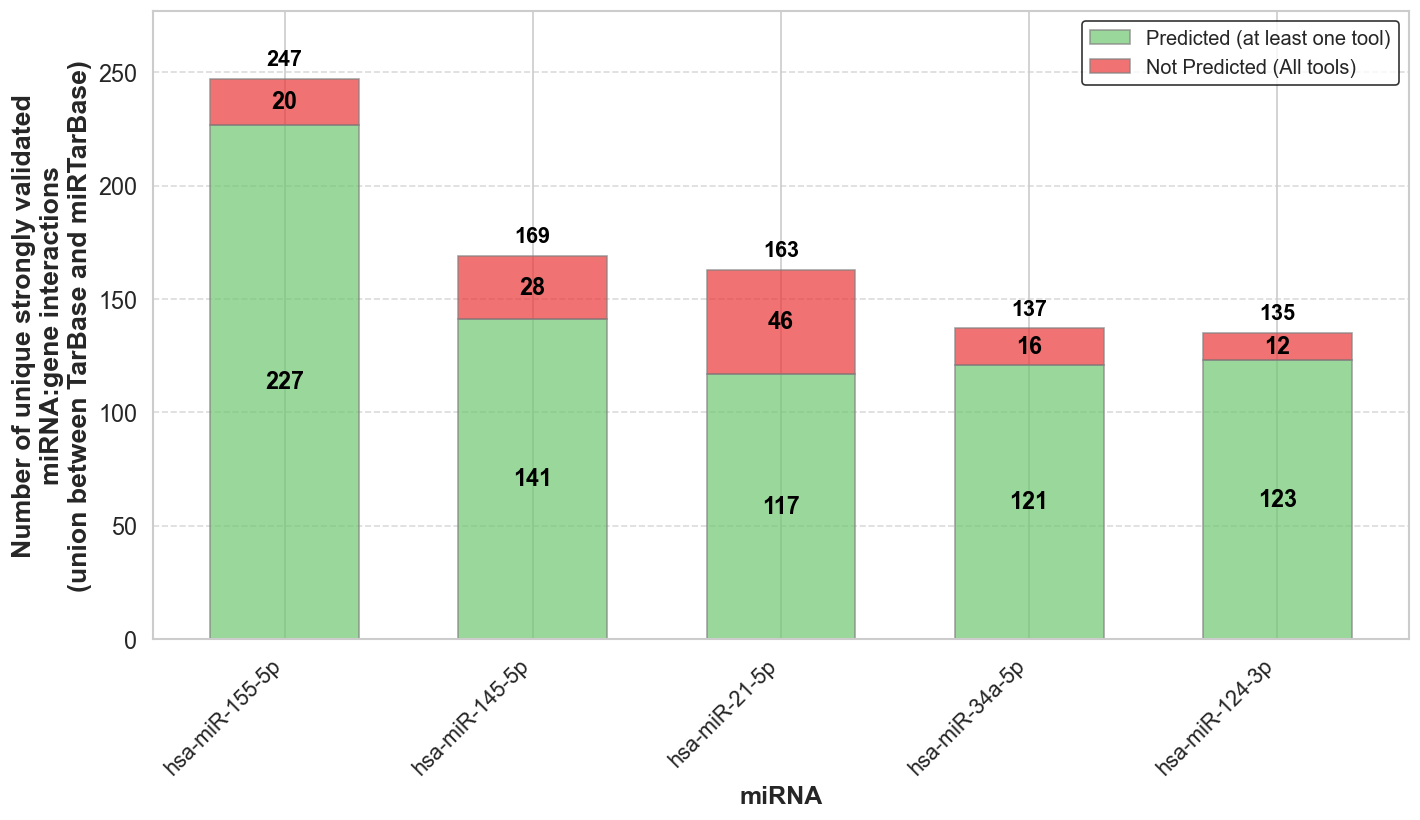

In [67]:
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 7), dpi=120)
bar_width = 0.6

miRNAs = df_plot.index.tolist()
true_positives_predicted = df_plot["Predicted"].tolist()
not_predicted_all_tools = df_plot["Not Predicted"].tolist()
true_positives_total = df_plot["Total"].tolist()

colors = {
    "Predicted (at least one tool)": "#6fc76f",
    "Not Predicted (All tools)": "#eb3636"
}

p1 = ax.bar(miRNAs, true_positives_predicted, bar_width,
            label="Predicted (at least one tool)",
            color=colors["Predicted (at least one tool)"],
            edgecolor='grey', linewidth=1, alpha=0.7)

p2 = ax.bar(miRNAs, not_predicted_all_tools, bar_width,
            bottom=true_positives_predicted,
            label="Not Predicted (All tools)",
            color=colors["Not Predicted (All tools)"],
            edgecolor='grey', linewidth=1, alpha=0.7)

ax.set_ylim(0, max(true_positives_total) + 30)

ax.set_xlabel("miRNA", fontsize=15, fontweight="bold")
ax.set_ylabel("Number of unique strongly validated\nmiRNA:gene interactions\n(union between TarBase and miRTarBase)", fontsize=16, fontweight="bold")

plt.xticks(rotation=45, ha="right", fontsize=13)
ax.tick_params(axis='y', labelsize=14)

ax.grid(axis="y", linestyle="--", alpha=0.7)

for bars in [p1, p2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + height / 2,
                str(int(height)),
                ha="center", va="center",
                fontsize=14, color="black", fontweight="bold"
            )

for i, total in enumerate(true_positives_total):
    ax.text(i, total + 6, str(total), ha="center", fontsize=13, fontweight="bold", color="black")

ax.legend(loc="upper right", fontsize=12, frameon=True, facecolor='white', edgecolor='black')

plt.tight_layout()

save_chart = input("Do you want to save the chart as a PNG file? (yes/no): ").strip().lower()
if save_chart == "yes":
    filename = "miRNA_TruePositives_StackedBar_union_noTargetScan.png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    print(f"✅ Chart saved as '{filename}'")

plt.show()

In [ ]:
# Percentages not predicted/validated

In [29]:
tool_stats = defaultdict(list)

print("\n🔍 Not Predicted Validation Summary (per tool):")
print("------------------------------------------------")

for mirna in mirnas:
    validated = get_intersections(tarbase, mirtarbase, mirna) # get_intersections for intersection, get_union_validated for union
    validated['gene_upper'] = validated['gene'].str.upper()
    total = len(validated)
    
    tool_files = {
        "DIANA": f"{mirna} - Diana microT CDS.xlsx",
        "miRDB": f"{mirna} - miRDB.xlsx",
        "miRmap": f"{mirna} - mirmap.xlsx"
    }
    
    column_map = {
        "DIANA": "gene_symbol",
        "miRDB": "Gene Symbol",
        "miRmap": "Gene"
    }

    print(f"\nmiRNA: {mirna} (Total validated: {total})")
    
    for tool, file in tool_files.items():
        col = column_map[tool]
        if os.path.exists(file):
            df = pd.read_excel(file)
            if col in df.columns:
                predicted = df[col].dropna().astype(str).str.upper()
                not_predicted_genes = validated[~validated["gene_upper"].isin(predicted)]
                count = len(not_predicted_genes)
                pct = (count / total * 100) if total > 0 else 0
                tool_stats[tool].append(pct)
                print(f"  {tool}: {count} not predicted ({pct:.1f}%)")
            else:
                print(f"  {tool}: column '{col}' not found")
        else:
            print(f"  {tool}: file not found")

print("\n📊 Summary Statistics Across miRNAs")
print("------------------------------------")
for tool, percentages in tool_stats.items():
    mean_val = np.mean(percentages)
    std_val = np.std(percentages)
    print(f"{tool} - Mean: {mean_val:.1f}%, Std: {std_val:.1f}%")


🔍 Not Predicted Validation Summary (per tool):
------------------------------------------------

miRNA: hsa-miR-155-5p (Total validated: 112)
  DIANA: 6 not predicted (5.4%)
  miRDB: 38 not predicted (33.9%)
  miRmap: 22 not predicted (19.6%)

miRNA: hsa-miR-145-5p (Total validated: 35)
  DIANA: 5 not predicted (14.3%)
  miRDB: 20 not predicted (57.1%)
  miRmap: 14 not predicted (40.0%)

miRNA: hsa-miR-21-5p (Total validated: 41)
  DIANA: 7 not predicted (17.1%)
  miRDB: 26 not predicted (63.4%)
  miRmap: 12 not predicted (29.3%)

miRNA: hsa-miR-34a-5p (Total validated: 40)
  DIANA: 2 not predicted (5.0%)
  miRDB: 12 not predicted (30.0%)
  miRmap: 7 not predicted (17.5%)

miRNA: hsa-miR-124-3p (Total validated: 29)
  DIANA: 0 not predicted (0.0%)
  miRDB: 3 not predicted (10.3%)
  miRmap: 1 not predicted (3.4%)

📊 Summary Statistics Across miRNAs
------------------------------------
DIANA - Mean: 8.3%, Std: 6.3%
miRDB - Mean: 39.0%, Std: 19.3%
miRmap - Mean: 22.0%, Std: 12.2%


In [ ]:
# KDE Plots for validated targets that are predicted

In [39]:
# Define shared variables
mirna_ids = {
    "hsa-miR-21-5p": "miR-21-5p",
    "hsa-miR-34a-5p": "miR-34a-5p",
    "hsa-miR-124-3p": "miR-124-3p",
    "hsa-miR-145-5p": "miR-145-5p",
    "hsa-miR-155-5p": "miR-155-5p"
}

mirna_colors = {
    "miR-21-5p": "#ff9999",
    "miR-34a-5p": "#66b3ff",
    "miR-124-3p": "#99ff99",
    "miR-145-5p": "#ffcc99",
    "miR-155-5p": "#c2c2f0"
}

tools = {
    "DIANA-microT-CDS": {"file_suffix": "Diana microT CDS.xlsx", "score_col": "interaction_score"},
    "MirTarget": {"file_suffix": "miRDB.xlsx", "score_col": "Target Score"},
    "miRmap": {"file_suffix": "mirmap.xlsx", "score_col": "miRmap score"}
}

gene_col_map = {
    "DIANA-microT-CDS": "gene_symbol",
    "MirTarget": "Gene Symbol",
    "miRmap": "Gene"
}

tool_colors = {
    "DIANA-microT-CDS": {
        "mean": "#6fc76f", 
        "std": "#6ecc6e"
    },
    "MirTarget": {
        "mean": "#eb3636",
        "std": "#e38a86"
    },
    "miRmap": {
        "mean": "#78a7d1",
        "std": "#82b8ed"
    }
}

x_label_map = {
    "DIANA-microT-CDS": 'Prediction Score ("interaction score")',
    "MirTarget": 'Prediction Score ("Target Score")',
    "miRmap": 'Prediction Score ("miRmap score")'
}


📈 Generating KDE for DIANA-microT-CDS...

📌 DIANA-microT-CDS — Max KDE at prediction score: 0.94
    75% of that value: 0.71


Save DIANA-microT-CDS KDE as PNG? (yes/no):  yes


✅ Saved as 'DIANA-microT-CDS_KDE_STD_VALIDATED_UNION.png'.


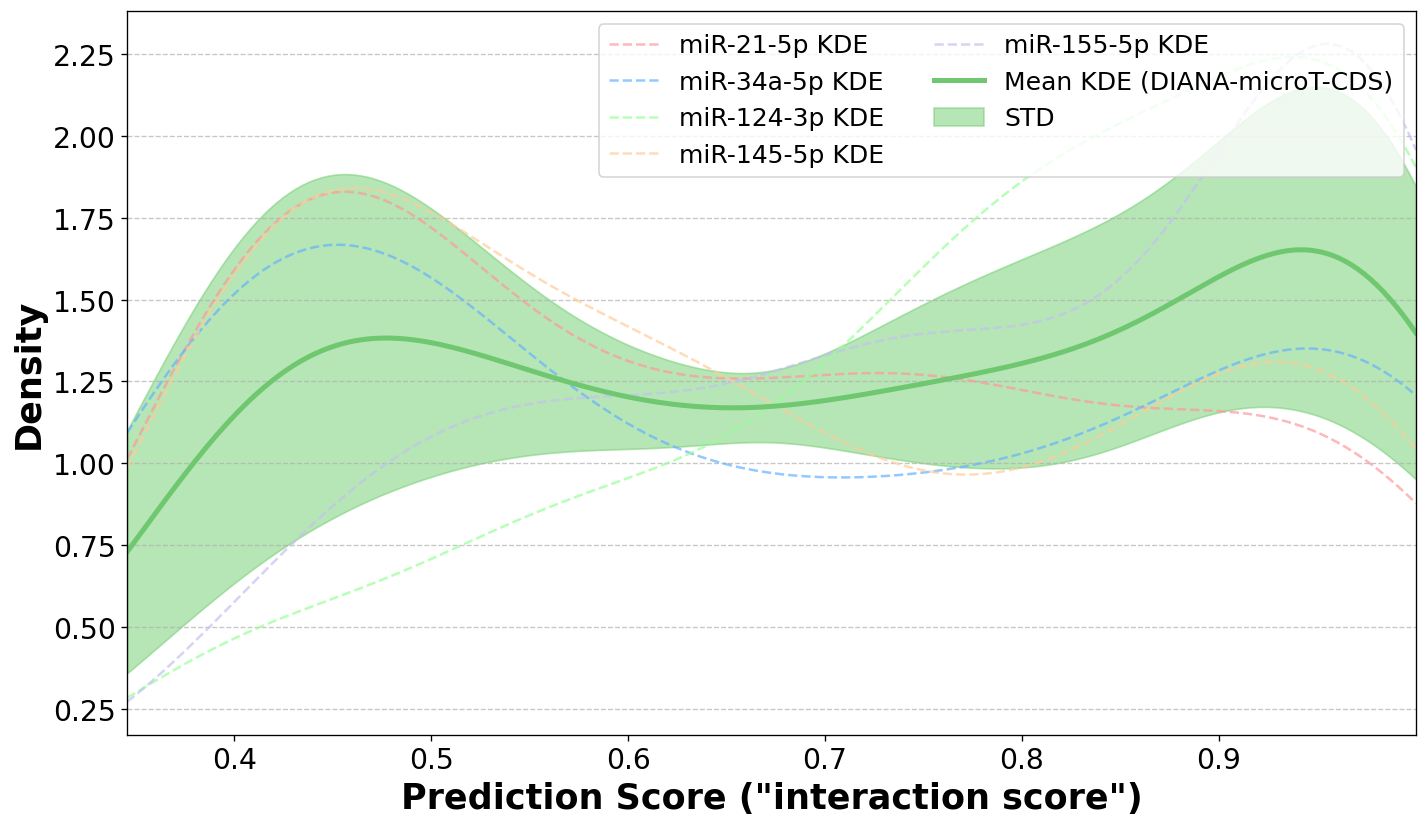


📈 Generating KDE for MirTarget...

📌 MirTarget — Max KDE at prediction score: 89.45
    75% of that value: 67.09


Save MirTarget KDE as PNG? (yes/no):  yes


✅ Saved as 'MirTarget_KDE_STD_VALIDATED_UNION.png'.


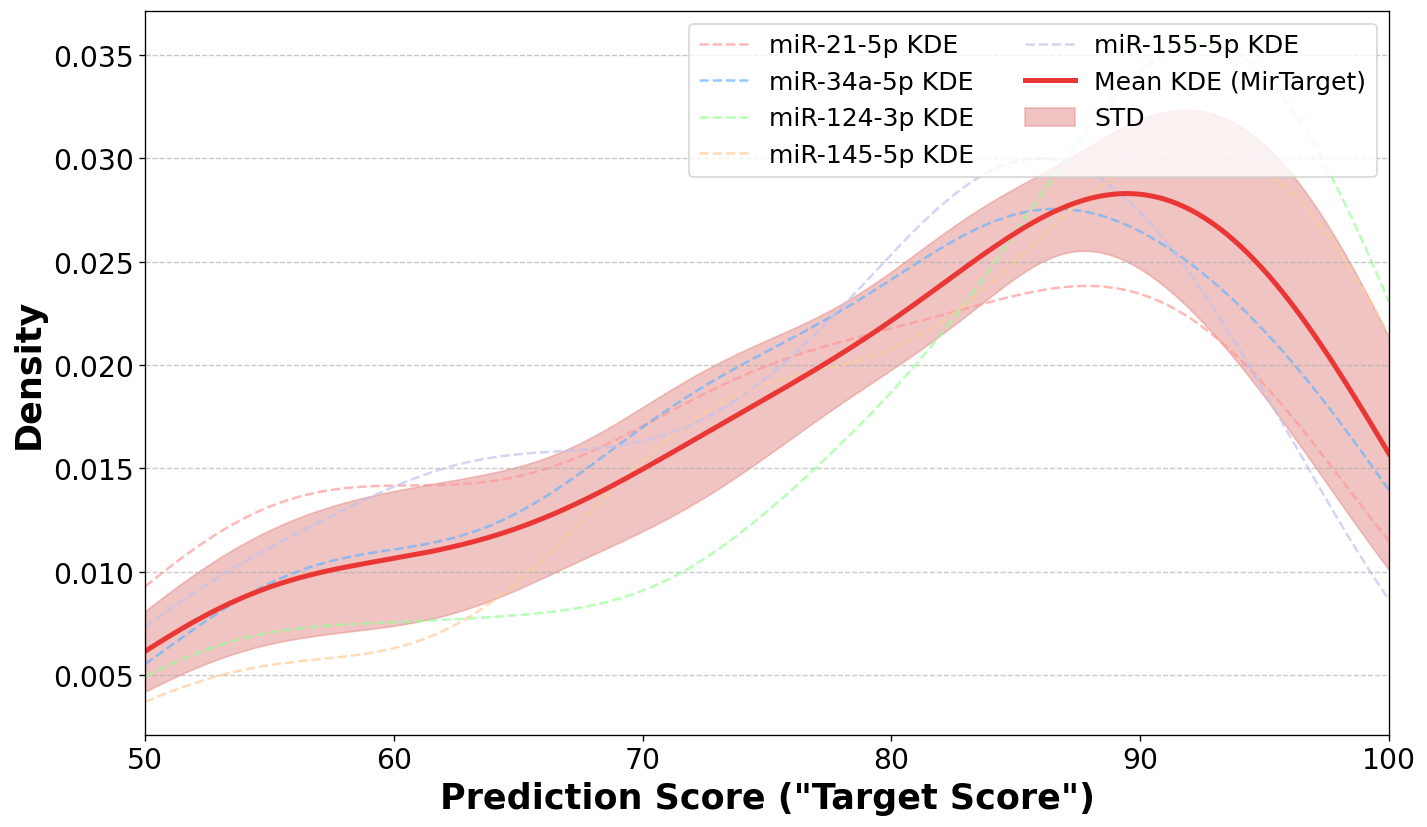


📈 Generating KDE for miRmap...

📌 miRmap — Max KDE at prediction score: 89.92
    75% of that value: 67.44


Save miRmap KDE as PNG? (yes/no):  yes


✅ Saved as 'miRmap_KDE_STD_VALIDATED_UNION.png'.


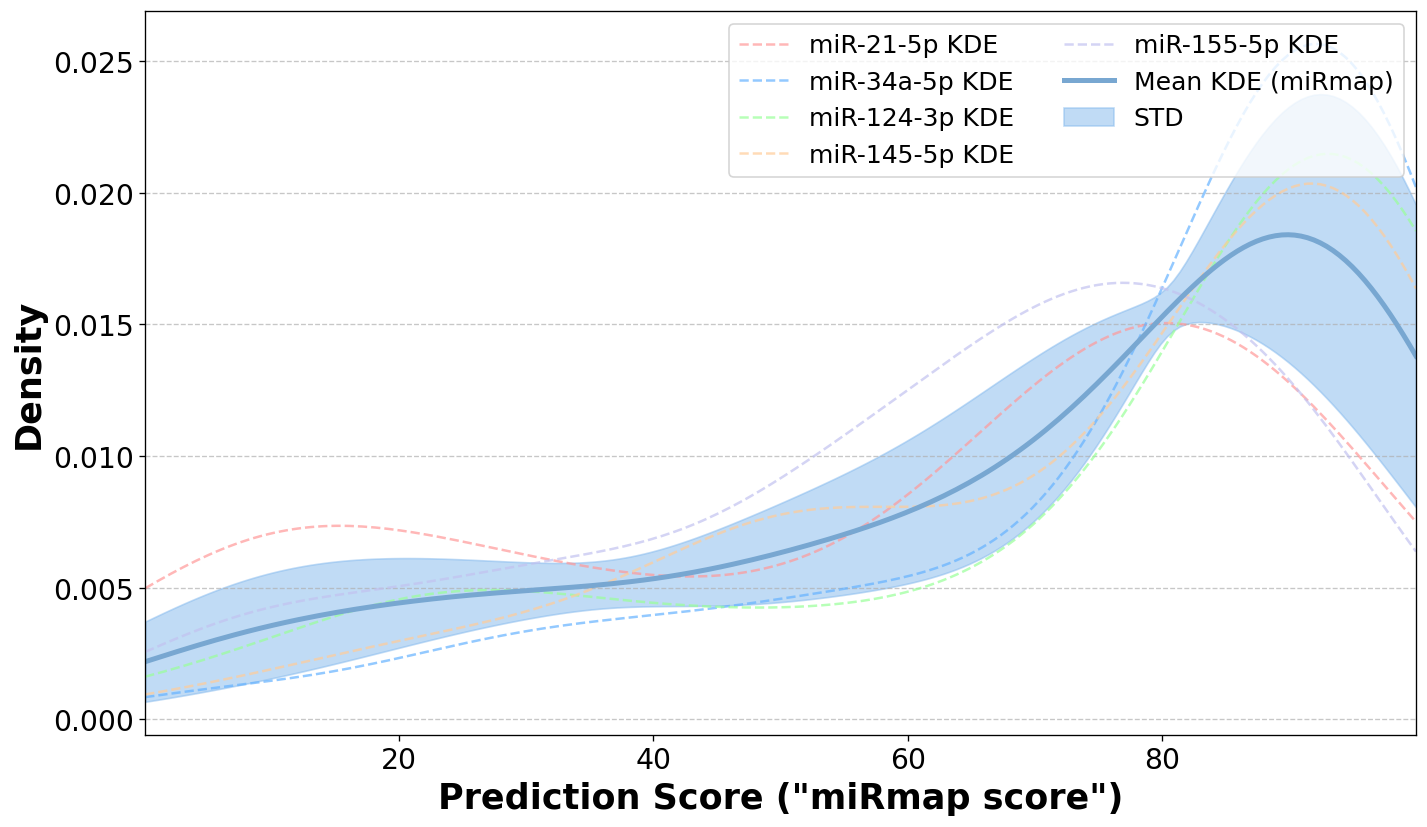

In [41]:
for tool, cfg in tools.items():
    print(f"\nGenerating KDE for {tool}...")

    mirna_kde_data = {}
    all_kde_values = []
    all_raw_scores = []

    for full_mirna in mirna_ids.keys():
        file = f"{full_mirna} - {cfg['file_suffix']}"
        score_col = cfg["score_col"]

        if not os.path.exists(file):
            continue

        try:
            df = pd.read_excel(file)
            if score_col not in df.columns:
                continue

            scores = pd.to_numeric(df[score_col], errors='coerce').dropna().tolist()
            all_raw_scores.extend(scores)

        except Exception as e:
            print(f"Error reading {file} for x-axis setup: {e}")
            continue

    if len(all_raw_scores) < 2:
        print(f"Not enough scores to set x-axis for {tool}. Skipping...")
        continue

    x_min = min(all_raw_scores)
    x_max = max(all_raw_scores)
    x_common = np.linspace(x_min, x_max, 200)

    for full_mirna, short_mirna in mirna_ids.items():
        file = f"{full_mirna} - {cfg['file_suffix']}"
        score_col = cfg["score_col"]
        gene_col = gene_col_map[tool]

        # Get union or intersection of validated genes
        validated = get_union_validated(tarbase, mirtarbase, full_mirna) # get_union_validated for union, get_intersections for intersection
        validated['gene_upper'] = validated['gene'].astype(str).str.strip().str.upper()

        if not os.path.exists(file):
            print(f"File not found: {file}")
            continue

        try:
            df = pd.read_excel(file)

            if score_col not in df.columns:
                print(f"⚠️ Score column '{score_col}' not found in {file}")
                continue
            if gene_col not in df.columns:
                print(f"⚠️ Gene column '{gene_col}' not found in {file}")
                continue

            df['gene_upper'] = df[gene_col].astype(str).str.strip().str.upper()
            df[score_col] = pd.to_numeric(df[score_col], errors='coerce')

            validated_scores = df[df['gene_upper'].isin(validated['gene_upper'])][score_col].dropna()

            if not validated_scores.empty:
                scores = validated_scores.tolist()
                mirna_kde_data[short_mirna] = scores

        except Exception as e:
            print(f"⚠️ Error processing {file}: {e}")

    if not mirna_kde_data:
        print(f"⚠️ No valid data for {tool}")
        continue

    kde_results = {}
    for mirna, scores in mirna_kde_data.items():
        if len(set(scores)) < 2:
            print(f"⚠️ Skipping KDE for {tool} – {mirna}: scores have no variance")
            continue
        kde = gaussian_kde(scores)
        kde_values = kde(x_common)
        kde_results[mirna] = kde_values
        all_kde_values.append(kde_values)

    if not all_kde_values:
        print(f"⚠️ All KDEs skipped for {tool} due to flat score sets.")
        continue

    mean_kde = np.mean(all_kde_values, axis=0)
    std_kde = np.std(all_kde_values, axis=0)
    std_kde = np.maximum(std_kde, 1e-6)

    max_idx = np.argmax(mean_kde)
    x_at_max_density = x_common[max_idx]
    x_75_percent = 0.75 * x_at_max_density

    print(f"\n📌 {tool} — Max KDE at prediction score: {x_at_max_density:.2f}")
    print(f"    75% of that value: {x_75_percent:.2f}")

    plt.figure(figsize=(12, 7), dpi=120)
    for mirna, kde_values in kde_results.items():
        plt.plot(x_common, kde_values, linestyle="--", color=mirna_colors[mirna], alpha=0.7, label=f"{mirna} KDE")

    mean_color = tool_colors[tool]["mean"]
    std_color = tool_colors[tool]["std"]

    plt.plot(x_common, mean_kde, color=mean_color, linewidth=3, label=f"Mean KDE ({tool})")
    plt.fill_between(x_common, mean_kde - std_kde, mean_kde + std_kde, color=std_color, alpha=0.5, label="STD")

    plt.xlabel(x_label_map[tool], fontsize=21, fontweight="bold")
    plt.ylabel('Density', fontsize=21, fontweight="bold")
    plt.xlim(x_min, x_max)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(fontsize=15, loc='upper right', ncol=2)
    plt.tick_params(axis='both', labelsize=17)
    plt.tight_layout()

    save_plot = input(f"Save {tool} KDE as PNG? (yes/no): ").strip().lower()
    if save_plot == 'yes':
        fname = f"{tool.replace(' ', '_')}_KDE_STD_VALIDATED_UNION.png"
        plt.savefig(fname, dpi=300, bbox_inches='tight')
        print(f"✅ Saved as '{fname}'.")

    plt.show()

In [75]:
print("\n📊 Median Prediction Score for Predicted & Validated Genes:")
print("-------------------------------------------------------------")

for tool, cfg in tools.items():
    pooled_scores = []
    score_col = cfg["score_col"]
    gene_col = gene_col_map[tool]

    for full_mirna in mirna_ids.keys():
        file = f"{full_mirna} - {cfg['file_suffix']}"
        if not os.path.exists(file):
            continue

        try:
            df = pd.read_excel(file)
            if gene_col not in df.columns or score_col not in df.columns:
                continue

            df['gene_upper'] = df[gene_col].astype(str).str.strip().str.upper()
            df[score_col] = pd.to_numeric(df[score_col], errors='coerce')

            validated = get_intersections(tarbase, mirtarbase, full_mirna) # get_union_validated for union, #get_intersections for intersection
            validated['gene_upper'] = validated['gene'].astype(str).str.strip().str.upper()

            matched = df[df['gene_upper'].isin(validated['gene_upper'])]
            scores = matched[score_col].dropna().tolist()
            pooled_scores.extend(scores)

        except Exception as e:
            print(f"⚠️ Error for {tool} - {full_mirna}: {e}")

    if pooled_scores:
        median_val = np.median(pooled_scores)
        print(f"{tool}: Median prediction score = {median_val:.2f} (n={len(pooled_scores)})")
    else:
        print(f"{tool}: No overlapping predictions with validated genes.")


📊 Median Prediction Score for Predicted & Validated Genes:
-------------------------------------------------------------
DIANA-microT-CDS: Median prediction score = 0.84 (n=238)
MirTarget: Median prediction score = 86.00 (n=158)
miRmap: Median prediction score = 80.52 (n=201)


In [1]:
# UNION:

# max KDE - 25 % - 
#DIANA-microT-CDS — Max KDE at prediction score: 0.94
#75% of that value: 0.71

#MirTarget — Max KDE at prediction score: 89.45
#75% of that value: 67.09

#miRmap — Max KDE at prediction score: 89.92
#75% of that value: 67.44

# Pooled medians - union:

#Median Prediction Score for Predicted & Validated Genes - UNION:
-------------------------------------------------------------
#DIANA-microT-CDS: Median prediction score = 0.74 (n=710)
#MirTarget: Median prediction score = 84.00 (n=384)
#miRmap: Median prediction score = 78.09 (n=554)

# INTERSECTION

# max KDE - 25 % -
#DIANA-microT-CDS — Max KDE at prediction score: 0.96
#75% of that value: 0.72

#MirTarget — Max KDE at prediction score: 89.45
#75% of that value: 67.09

#miRmap — Max KDE at prediction score: 90.93
#75% of that value: 68.19

# Pooled medians - intersection:
#Median Prediction Score for Predicted & Validated Genes - INTERSECTION:
-------------------------------------------------------------
#DIANA-microT-CDS: Median prediction score = 0.84 (n=238)
#MirTarget: Median prediction score = 86.00 (n=158)
#miRmap: Median prediction score = 80.52 (n=201)

SyntaxError: invalid syntax (3830736149.py, line 16)

In [3]:
# Union vs Intersection (non-predicted/validated ratio) - Mann Whitney U test

union = [20/247, 28/169, 46/163, 16/137, 12/135]
intersection = [4/112, 5/35, 7/41, 2/40, 0/29]

stat, p = mannwhitneyu(union, intersection, alternative='two-sided')

print(f"U statistic = {stat:.3f}")
print(f"p-value = {p:.4f}")

U statistic = 18.000
p-value = 0.3095


In [ ]:
# PART2: Mean overlap between prediction tools - adjusted Jaccard (Chapter 2.3)

In [83]:
# Define files and gene column map
tool_names = {
    "DIANA": "Diana microT CDS.xlsx",
    "MirTarget": "miRDB.xlsx",
    "miRmap": "mirmap.xlsx"
}

In [93]:
# Store adjusted jaccard scores per combination label
adj_jaccard_scores = defaultdict(list)

print("\nAdjusted Jaccard Indices (All 2-way and 3-way Tool Combinations)")
print("------------------------------------------------------------------")

for full_mirna in mirna_ids.keys():
    short_mirna = mirna_ids[full_mirna]
    print(f"\nmiRNA: {short_mirna}")

    # Cache gene sets for tools
    gene_sets = {}

    for tool, filename in tool_names.items():
        file_path = f"{full_mirna} - {filename}"
        col = gene_col_map[tool]

        if not os.path.exists(file_path):
            print(f"  {tool}: file not found.")
            gene_sets[tool] = set()
            continue

        try:
            df = pd.read_excel(file_path)
            if col not in df.columns:
                print(f"  {tool}: column '{col}' not found.")
                gene_sets[tool] = set()
                continue

            genes = df[col].dropna().astype(str).str.strip().str.upper()
            gene_sets[tool] = set(genes)
            print(f"  {tool} predicted genes: {len(gene_sets[tool])}")

        except Exception as e:
            print(f"  {tool}: error reading file: {e}")
            gene_sets[tool] = set()

    # Generate all combinations (2-way and 3-way)
    for r in [2, 3]:
        for combo in combinations(tool_names.keys(), r):
            sets = [gene_sets[tool] for tool in combo]

            if any(len(s) == 0 for s in sets):
                print(f"  Skipped adjusted Jaccard for {combo} — missing predictions.")
                continue

            intersection = set.intersection(*sets)
            min_size = min(len(s) for s in sets)
            adj_jaccard = len(intersection) / min_size if min_size > 0 else 0

            label = ", ".join(combo)
            adj_jaccard_scores[label].append(adj_jaccard)
            print(f"  Adjusted Jaccard ({label}): {adj_jaccard:.3f}")


Adjusted Jaccard Indices (All 2-way and 3-way Tool Combinations)
------------------------------------------------------------------

miRNA: miR-21-5p
  DIANA predicted genes: 7329
  miRDB predicted genes: 469
  miRmap predicted genes: 3561
  Adjusted Jaccard (DIANA, miRDB): 0.966
  Adjusted Jaccard (DIANA, miRmap): 0.855
  Adjusted Jaccard (miRDB, miRmap): 0.776
  Adjusted Jaccard (DIANA, miRDB, miRmap): 0.768

miRNA: miR-34a-5p
  DIANA predicted genes: 11944
  miRDB predicted genes: 899
  miRmap predicted genes: 4642
  Adjusted Jaccard (DIANA, miRDB): 0.970
  Adjusted Jaccard (DIANA, miRmap): 0.880
  Adjusted Jaccard (miRDB, miRmap): 0.811
  Adjusted Jaccard (DIANA, miRDB, miRmap): 0.798

miRNA: miR-124-3p
  DIANA predicted genes: 11031
  miRDB predicted genes: 1648
  miRmap predicted genes: 7059
  Adjusted Jaccard (DIANA, miRDB): 0.973
  Adjusted Jaccard (DIANA, miRmap): 0.875
  Adjusted Jaccard (miRDB, miRmap): 0.836
  Adjusted Jaccard (DIANA, miRDB, miRmap): 0.824

miRNA: miR-145-

In [95]:
# Summary
print("\nSummary: Adjusted Jaccard Indices ± Sample STD")
print("------------------------------------------------")
for combo_label, values in adj_jaccard_scores.items():
    mean_val = np.mean(values)
    std_val = np.std(values, ddof=1) if len(values) > 1 else 0
    print(f"{combo_label:<35} {mean_val:.3f} ± {std_val:.3f}")


Summary: Adjusted Jaccard Indices ± Sample STD
------------------------------------------------
DIANA, miRDB                        0.967 ± 0.004
DIANA, miRmap                       0.870 ± 0.009
miRDB, miRmap                       0.798 ± 0.025
DIANA, miRDB, miRmap                0.783 ± 0.027


In [99]:
# Mean ± Sample SD of predicted gene counts per tool
print("\nSummary: Mean ± Sample SD of Predicted Gene Counts per Tool")
print("-------------------------------------------------------------")

for tool, filename in tool_names.items():
    counts = []

    for full_mirna in mirna_ids.keys():
        file_path = f"{full_mirna} - {filename}"
        col = gene_col_map[tool]

        if not os.path.exists(file_path):
            continue

        try:
            df = pd.read_excel(file_path)
            if col in df.columns:
                count = df[col].dropna().astype(str).str.strip().str.upper().nunique()
                counts.append(count)
        except Exception as e:
            continue

    if counts:
        mean_val = np.mean(counts)
        std_val = np.std(counts, ddof=1)
        print(f"{tool:<7}: {mean_val:.1f} ± {std_val:.1f} (n={len(counts)})")
    else:
        print(f"{tool:<7}: No valid data found.")


Summary: Mean ± Sample SD of Predicted Gene Counts per Tool
-------------------------------------------------------------
DIANA  : 9913.2 ± 1979.6 (n=5)
miRDB  : 925.2 ± 442.1 (n=5)
miRmap : 4732.6 ± 1452.4 (n=5)
